In [1]:
# 4F13 Machine Learning: Coursework #3 - Latent Dirichlet Allocation
# Import required libraries
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix as sparse
from scipy.special import gammaln
from sampleDiscrete import sampleDiscrete

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
data = sio.loadmat('kos_doc_data.mat')
A = np.array(data['A'])  # Training data: [doc_id, word_id, count]
B = np.array(data['B'])  # Test data: [doc_id, word_id, count]
V = data['V']            # Vocabulary

print(f"Training data shape: {A.shape}")
print(f"Test data shape: {B.shape}")
print(f"Vocabulary size: {len(V)}")
print(f"Number of training documents: {np.max(A[:, 0])}")
print(f"Number of test documents: {len(np.unique(B[:, 0]))}")

Training data shape: (205211, 3)
Test data shape: (147949, 3)
Vocabulary size: 6906
Number of training documents: 2000
Number of test documents: 1430


/Users/ragharao/Desktop/4F13/cw3/sampleDiscrete.py:4: SyntaxWarning: invalid escape sequence '\i'
  """


In [24]:
print(len(set([V[i][0][0] for i in range(len(V))])))

6906


# Part (a): Maximum Likelihood Multinomial

We find the maximum likelihood multinomial over words using the training data. The ML estimate is simply the normalized word counts:

$$\hat{p}_w^{ML} = \frac{n_w}{\sum_{w'} n_{w'}}$$

where $n_w$ is the total count of word $w$ across all training documents.

In [2]:
# Part (a): Maximum Likelihood Multinomial
# Compute the total count of each word across all training documents
W = len(V)  # Total number of unique words in vocabulary

# Create word count vector: count for each word across all documents
word_counts = np.zeros(W)
for i in range(len(A)):
    word_id = A[i, 1] - 1  # word_id is 1-indexed, convert to 0-indexed
    count = A[i, 2]
    word_counts[word_id] += count

total_words = np.sum(word_counts)
print(f"Total word count in training set: {int(total_words)}")

# ML estimate: p_w = n_w / N
p_ml = word_counts / total_words

print(f"Sum of probabilities: {np.sum(p_ml):.6f}")  # Should be 1.0

# Find top 20 words by probability
top_20_indices = np.argsort(p_ml)[-20:][::-1]
top_20_probs = p_ml[top_20_indices]
top_20_words = [V[i][0][0] for i in top_20_indices]

print("\nTop 20 words by ML probability:")
for i, (word, prob) in enumerate(zip(top_20_words, top_20_probs)):
    print(f"{i+1}. {word}: {prob:.6f}")

Total word count in training set: 271898
Sum of probabilities: 1.000000

Top 20 words by ML probability:
1. bush: 0.014097
2. kerry: 0.009676
3. november: 0.008411
4. poll: 0.005701
5. house: 0.005359
6. democratic: 0.005344
7. general: 0.004987
8. war: 0.004972
9. iraq: 0.004686
10. senate: 0.004505
11. republicans: 0.004329
12. campaign: 0.004020
13. democrats: 0.003887
14. president: 0.003843
15. people: 0.003534
16. election: 0.003527
17. vote: 0.003446
18. republican: 0.003431
19. state: 0.003428
20. time: 0.003409


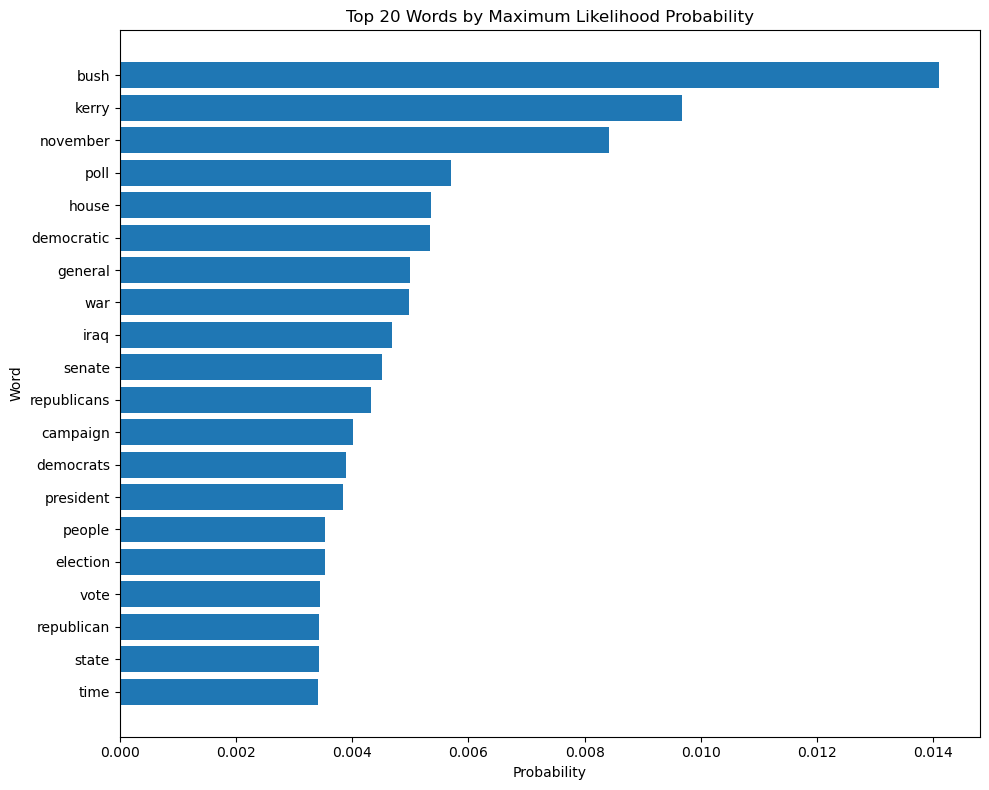


Number of words with zero ML probability: 14
Number of words with non-zero ML probability: 6892

Highest word probability: 0.014097
Highest possible log probability per word: -4.2618

Lowest possible log probability: -infinity (for words not in training)


In [3]:
# Plot horizontal bar chart for top 20 words
plt.figure(figsize=(10, 8))
plt.barh(range(20), top_20_probs[::-1])
plt.yticks(range(20), top_20_words[::-1])
plt.xlabel('Probability')
plt.ylabel('Word')
plt.title('Top 20 Words by Maximum Likelihood Probability')
plt.tight_layout()
plt.show()

# Compute highest and lowest possible test set log probability
# For ML model: p(w) = n_w / N for training words
# Words not seen in training have p(w) = 0

# Count words with zero probability
zero_prob_words = np.sum(p_ml == 0)
non_zero_prob_words = W - zero_prob_words
print(f"\nNumber of words with zero ML probability: {zero_prob_words}")
print(f"Number of words with non-zero ML probability: {non_zero_prob_words}")

# Highest log probability: test set contains only the most common word
p_max = np.max(p_ml)
log_p_max = np.log(p_max)
print(f"\nHighest word probability: {p_max:.6f}")
print(f"Highest possible log probability per word: {log_p_max:.4f}")

# Lowest log probability: test set contains a word not seen in training
# This would give log(0) = -infinity
print(f"\nLowest possible log probability: -infinity (for words not in training)")

# For any word in test that wasn't in training: log(0) = -inf
# This makes the entire test set log probability = -inf

## Part (a) Analysis and Implications

**Key Observations:**
1. The top 20 words are mostly political terms (bush, kerry, democratic, republican, etc.), which makes sense for the Daily Kos blog dataset.
2. The most common word "bush" has only ~1.4% probability, showing the distribution is quite spread out.

**Log Probability Bounds:**

- **Highest possible test log probability:** $\log(0.014097) \approx -4.26$ per word. This occurs if the test set contains only the most frequent word ("bush").

- **Lowest possible test log probability:** $-\infty$. This occurs if the test set contains ANY word that doesn't appear in the training set. Since there are 14 words in the vocabulary with zero training count, encountering any of these results in $\log(0) = -\infty$.

**Implications:**
1. **Zero probability problem:** The ML estimate assigns zero probability to words not seen in training. This is a critical flaw - if even one test word wasn't in training, the entire test set has zero probability (log probability = $-\infty$).

2. **Overconfidence on rare words:** ML estimation is overly confident that rare training words will remain rare, and completely rules out unseen words.

3. **Need for smoothing:** This motivates Bayesian approaches with priors that assign small but non-zero probability to all words, as we'll see in part (b).

# Part (b): Bayesian Inference with Dirichlet Prior

Instead of the ML estimate, we use Bayesian inference with a symmetric Dirichlet prior with concentration parameter $\alpha$ on the word probabilities.

## Mathematical Derivation

**Prior:** The Dirichlet prior on the multinomial parameters $\boldsymbol{p} = (p_1, ..., p_W)$ is:
$$p(\boldsymbol{p}) = \text{Dir}(\boldsymbol{p} | \boldsymbol{\alpha}) = \frac{\Gamma(\sum_w \alpha_w)}{\prod_w \Gamma(\alpha_w)} \prod_w p_w^{\alpha_w - 1}$$

For a symmetric Dirichlet with concentration $\alpha$, we have $\alpha_w = \alpha$ for all $w$.

**Posterior:** The posterior after observing word counts $\boldsymbol{n} = (n_1, ..., n_W)$ is:
$$p(\boldsymbol{p} | \boldsymbol{n}) = \text{Dir}(\boldsymbol{p} | \boldsymbol{\alpha} + \boldsymbol{n})$$

**Predictive Distribution:** The predictive probability for word $w$ is the expected value of $p_w$ under the posterior:
$$\hat{p}_w^{\text{Bayes}} = \mathbb{E}[p_w | \boldsymbol{n}] = \frac{n_w + \alpha}{\sum_{w'} (n_{w'} + \alpha)} = \frac{n_w + \alpha}{N + W\alpha}$$

where $N = \sum_w n_w$ is the total word count and $W$ is the vocabulary size.

## Comparison with ML Estimate

| | ML Estimate | Bayesian Estimate |
|---|---|---|
| Formula | $\hat{p}_w = \frac{n_w}{N}$ | $\hat{p}_w = \frac{n_w + \alpha}{N + W\alpha}$ |
| Unseen words ($n_w=0$) | $\hat{p}_w = 0$ | $\hat{p}_w = \frac{\alpha}{N + W\alpha} > 0$ |
| Common words | $\frac{n_w}{N}$ | Slightly decreased |
| Effect of $\alpha$ | N/A | Controls smoothing strength |

In [4]:
# Part (b): Compare ML and Bayesian estimates for different alpha values
N = total_words  # Total word count

# Function to compute Bayesian predictive probability
def bayesian_prob(word_counts, alpha, W):
    N = np.sum(word_counts)
    return (word_counts + alpha) / (N + W * alpha)

# Compare for different alpha values
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]

print("Comparison of ML and Bayesian estimates\n")
print(f"Total words N = {int(N)}, Vocabulary size W = {W}")
print("="*80)

# Example words: most common word, a rare word, and unseen word
most_common_idx = top_20_indices[0]
rare_word_idx = np.where(word_counts == 1)[0][0]  # A word that appears exactly once
unseen_word_idx = np.where(word_counts == 0)[0][0]  # An unseen word

print(f"\nMost common word: '{V[most_common_idx][0][0]}' (count = {int(word_counts[most_common_idx])})")
print(f"Rare word: '{V[rare_word_idx][0][0]}' (count = 1)")
print(f"Unseen word: '{V[unseen_word_idx][0][0]}' (count = 0)")

print(f"\n{'Alpha':<10} {'Common (ML={p_ml[most_common_idx]:.6f})':<25} {'Rare (ML={p_ml[rare_word_idx]:.6f})':<25} {'Unseen (ML=0)':<20}")
print("-"*80)

for alpha in alphas:
    p_bayes = bayesian_prob(word_counts, alpha, W)
    print(f"{alpha:<10} {p_bayes[most_common_idx]:<25.6f} {p_bayes[rare_word_idx]:<25.6f} {p_bayes[unseen_word_idx]:<20.6f}")

Comparison of ML and Bayesian estimates

Total words N = 271898, Vocabulary size W = 6906

Most common word: 'bush' (count = 3833)
Rare word: 'accent' (count = 1)
Unseen word: 'alhusainy' (count = 0)

Alpha      Common (ML={p_ml[most_common_idx]:.6f}) Rare (ML={p_ml[rare_word_idx]:.6f}) Unseen (ML=0)       
--------------------------------------------------------------------------------
0.001      0.014097                  0.000004                  0.000000            
0.1        0.014062                  0.000004                  0.000000            
1.0        0.013752                  0.000007                  0.000004            
10.0       0.011271                  0.000032                  0.000029            
100.0      0.004086                  0.000105                  0.000104            


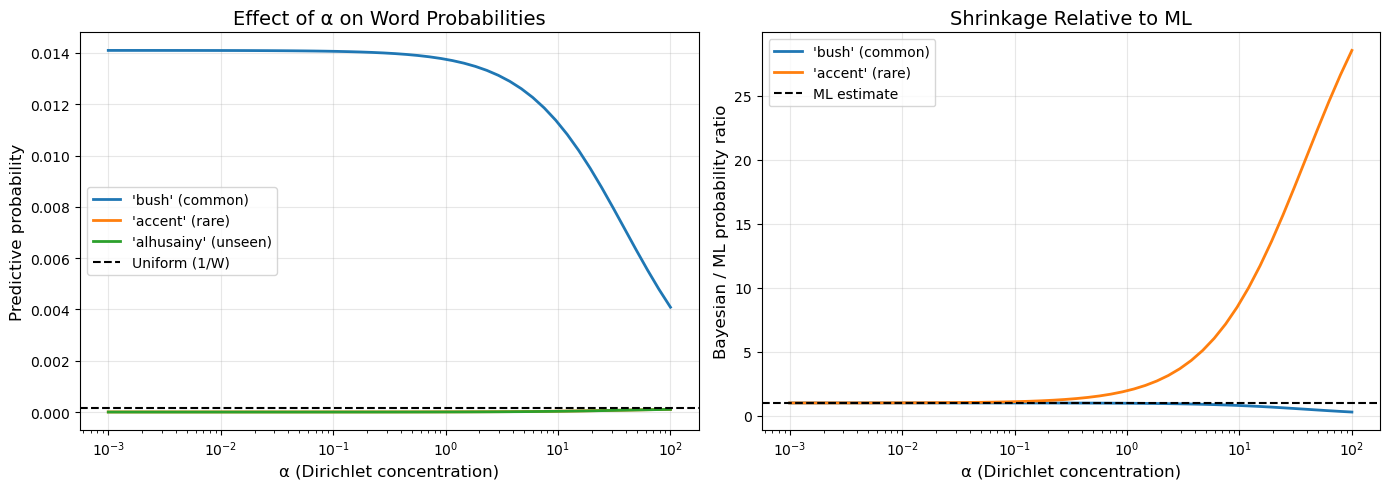

In [5]:
# Visualize the effect of alpha on word probability distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Effect on common vs rare words as a function of alpha
alphas_fine = np.logspace(-3, 2, 50)
common_probs = []
rare_probs = []
unseen_probs = []

for alpha in alphas_fine:
    p_bayes = bayesian_prob(word_counts, alpha, W)
    common_probs.append(p_bayes[most_common_idx])
    rare_probs.append(p_bayes[rare_word_idx])
    unseen_probs.append(p_bayes[unseen_word_idx])

ax = axes[0]
ax.semilogx(alphas_fine, common_probs, label=f"'{V[most_common_idx][0][0]}' (common)", linewidth=2)
ax.semilogx(alphas_fine, rare_probs, label=f"'{V[rare_word_idx][0][0]}' (rare)", linewidth=2)
ax.semilogx(alphas_fine, unseen_probs, label=f"'{V[unseen_word_idx][0][0]}' (unseen)", linewidth=2)
ax.axhline(y=1/W, color='k', linestyle='--', label='Uniform (1/W)')
ax.set_xlabel('α (Dirichlet concentration)', fontsize=12)
ax.set_ylabel('Predictive probability', fontsize=12)
ax.set_title('Effect of α on Word Probabilities', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Right plot: Ratio of Bayesian to ML probability
ax = axes[1]
common_ratio = np.array(common_probs) / p_ml[most_common_idx]
rare_ratio = np.array(rare_probs) / p_ml[rare_word_idx]

ax.semilogx(alphas_fine, common_ratio, label=f"'{V[most_common_idx][0][0]}' (common)", linewidth=2)
ax.semilogx(alphas_fine, rare_ratio, label=f"'{V[rare_word_idx][0][0]}' (rare)", linewidth=2)
ax.axhline(y=1.0, color='k', linestyle='--', label='ML estimate')
ax.set_xlabel('α (Dirichlet concentration)', fontsize=12)
ax.set_ylabel('Bayesian / ML probability ratio', fontsize=12)
ax.set_title('Shrinkage Relative to ML', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Part (b) Analysis: Implications for Common and Rare Words

### Effect of Small α (e.g., α = 0.1):
- **Common words:** The Bayesian estimate is very close to the ML estimate. The "bush" probability barely changes from 0.014097 to ~0.014062.
- **Rare words:** Still close to ML, but with a slight boost. Words seen once get slightly higher probability.
- **Unseen words:** Get tiny but non-zero probability ($\frac{\alpha}{N + W\alpha} \approx 3.6 \times 10^{-7}$). This is crucial - we avoid log(0) = -∞.

### Effect of Large α (e.g., α = 100):
- **Common words:** Shrinkage toward uniform. "Bush" drops from 0.014 to ~0.004.
- **Rare words:** Boosted significantly above ML. A word appearing once has probability ~0.0001 instead of ~0.000004.
- **Unseen words:** Get much higher probability (~0.0001), nearly equal to rare seen words.

### Summary of Implications:

| | Small α (sparse prior) | Large α (uniform prior) |
|---|---|---|
| Prior belief | Expect sparse distributions | Expect uniform distributions |
| Common words | Nearly ML estimate | Shrunk toward 1/W |
| Rare words | Slight boost over ML | Large boost toward 1/W |
| Unseen words | Very small probability | Significant probability |
| Risk | Near-ML behavior, small smoothing | Over-smoothing, lose information |

### Key Insight:
The Dirichlet prior with parameter α acts as **adding α pseudo-counts** to every word. This Laplace smoothing (α=1) or Jeffreys prior (α=0.5) provides a principled way to handle the zero-probability problem while controlling how much we trust the observed data vs. our prior belief in uniformity.

# Part (c): Test Document Log Probability and Perplexity

## Multinomial vs Categorical Distribution

**Question:** When computing the log probability of a test document, should we use the multinomial or categorical distribution function?

**Answer:** We use the **categorical distribution** (product of individual word probabilities), NOT the multinomial. Here's why:

1. **Multinomial:** Would give $P(\mathbf{n}) = \frac{N!}{\prod_w n_w!} \prod_w p_w^{n_w}$

2. **Categorical (what we use):** Gives $P(\mathbf{n}) = \prod_w p_w^{n_w}$

The multinomial coefficient $\frac{N!}{\prod_w n_w!}$ counts the number of orderings of words, which is a **constant** that depends only on the document's word counts, not on the model parameters. For model comparison (e.g., comparing perplexities), this constant cancels out. Using the categorical form simplifies computation and gives the same model rankings.

## Perplexity Definition

**Perplexity** measures how "surprised" the model is by the test data:
$$\text{Perplexity} = \exp\left(-\frac{1}{N_{\text{test}}} \sum_w n_w \log p_w\right)$$

This is the exponential of the negative average log probability per word. Lower perplexity = better model.

In [6]:
# Part (c): Compute log probability and perplexity for test documents
# Use Bayesian model with alpha = 0.1 (commonly used small value)
alpha = 0.1
p_bayes = bayesian_prob(word_counts, alpha, W)

# Function to compute log probability and perplexity for a document
def compute_doc_log_prob_and_perplexity(doc_id, data, p):
    """Compute log probability and perplexity for a single document."""
    doc_entries = np.where(data[:, 0] == doc_id)[0]
    word_ids = data[doc_entries, 1] - 1  # Convert to 0-indexed
    counts = data[doc_entries, 2]
    
    # Log probability: sum of n_w * log(p_w)
    log_prob = np.sum(counts * np.log(p[word_ids]))
    
    # Total word count in document
    total_words = np.sum(counts)
    
    # Per-word perplexity: exp(-log_prob / total_words)
    perplexity = np.exp(-log_prob / total_words)
    
    return log_prob, perplexity, total_words

# Compute for document 2001
doc_id_2001 = 2001
log_prob_2001, perplexity_2001, word_count_2001 = compute_doc_log_prob_and_perplexity(doc_id_2001, B, p_bayes)

print(f"Document ID: {doc_id_2001}")
print(f"Number of words: {int(word_count_2001)}")
print(f"Log probability: {log_prob_2001:.4f}")
print(f"Per-word perplexity: {perplexity_2001:.4f}")

Document ID: 2001
Number of words: 440
Log probability: -3691.2168
Per-word perplexity: 4398.9848


Number of test documents: 1430
Total test words: 195816
Total log probability: -1546933.6580

Overall per-word perplexity (all test documents): 2697.1068

Per-document perplexity statistics:
  Min: 399.2526
  Max: 15741.8272
  Mean: 2914.2168
  Median: 2790.9732


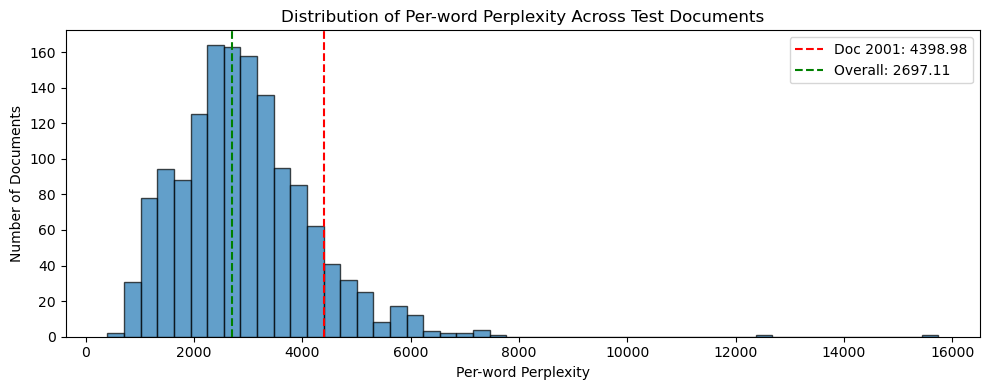

In [7]:
# Compute perplexity over all test documents in B
unique_test_docs = np.unique(B[:, 0])
total_log_prob = 0
total_test_words = 0
individual_perplexities = []

for doc_id in unique_test_docs:
    log_prob, perplexity, word_count = compute_doc_log_prob_and_perplexity(doc_id, B, p_bayes)
    total_log_prob += log_prob
    total_test_words += word_count
    individual_perplexities.append(perplexity)

# Overall perplexity for all test documents
overall_perplexity = np.exp(-total_log_prob / total_test_words)

print(f"Number of test documents: {len(unique_test_docs)}")
print(f"Total test words: {int(total_test_words)}")
print(f"Total log probability: {total_log_prob:.4f}")
print(f"\nOverall per-word perplexity (all test documents): {overall_perplexity:.4f}")

# Show distribution of per-document perplexities
print(f"\nPer-document perplexity statistics:")
print(f"  Min: {np.min(individual_perplexities):.4f}")
print(f"  Max: {np.max(individual_perplexities):.4f}")
print(f"  Mean: {np.mean(individual_perplexities):.4f}")
print(f"  Median: {np.median(individual_perplexities):.4f}")

# Plot histogram of per-document perplexities
plt.figure(figsize=(10, 4))
plt.hist(individual_perplexities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Per-word Perplexity')
plt.ylabel('Number of Documents')
plt.title('Distribution of Per-word Perplexity Across Test Documents')
plt.axvline(x=perplexity_2001, color='r', linestyle='--', label=f'Doc 2001: {perplexity_2001:.2f}')
plt.axvline(x=overall_perplexity, color='g', linestyle='--', label=f'Overall: {overall_perplexity:.2f}')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Compute perplexity for uniform multinomial
p_uniform = np.ones(W) / W
log_prob_uniform_2001 = 0
uniform_perplexity_per_doc = []

for doc_id in unique_test_docs:
    doc_entries = np.where(B[:, 0] == doc_id)[0]
    word_ids = B[doc_entries, 1] - 1
    counts = B[doc_entries, 2]
    total_doc_words = np.sum(counts)
    # For uniform, log(p_w) = log(1/W) for all words
    log_prob = total_doc_words * np.log(1/W)
    perp = np.exp(-log_prob / total_doc_words)  # exp(log(W)) = W
    uniform_perplexity_per_doc.append(perp)

# Uniform perplexity is exactly W for any document
print(f"Uniform multinomial perplexity = W = {W}")
print(f"Computed uniform perplexity (verification): {uniform_perplexity_per_doc[0]:.4f}")

# Summary comparison
print("\n" + "="*60)
print("SUMMARY: Perplexity Comparison")
print("="*60)
print(f"Document 2001 (Bayesian, α=0.1):        {perplexity_2001:.2f}")
print(f"Overall test set (Bayesian, α=0.1):    {overall_perplexity:.2f}")
print(f"Uniform multinomial:                    {W}")
print("\nNote: The Bayesian model achieves much lower perplexity than")
print("uniform, indicating it captures word frequency structure.")

Uniform multinomial perplexity = W = 6906
Computed uniform perplexity (verification): 6906.0000

SUMMARY: Perplexity Comparison
Document 2001 (Bayesian, α=0.1):        4398.98
Overall test set (Bayesian, α=0.1):    2697.11
Uniform multinomial:                    6906

Note: The Bayesian model achieves much lower perplexity than
uniform, indicating it captures word frequency structure.


## Part (c) Analysis

### Results Summary:
| Document/Model | Per-word Perplexity |
|---|---|
| Document 2001 (Bayesian, α=0.1) | 4398.98 |
| Overall test set (Bayesian, α=0.1) | 2697.11 |
| Uniform multinomial | 6906 (= W) |

### Why perplexities differ across documents:

1. **Document content:** Different documents use different vocabulary. Documents using more common words (high probability under the model) will have lower perplexity. Documents with unusual or rare words will have higher perplexity.

2. **Document length:** While perplexity is normalized per word, shorter documents have higher variance in their perplexity estimates.

3. **Topic alignment:** The training set is from Daily Kos (political blog). Test documents more aligned with typical political content will have lower perplexity.

4. **Document 2001's higher perplexity:** At 4398.98 (vs. overall 2697.11), this document likely contains more unusual words or covers less typical topics compared to the average test document.

### Why uniform perplexity = W:

For a uniform distribution: $p_w = 1/W$ for all words.

$$\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_w n_w \log(1/W)\right) = \exp\left(-\frac{1}{N} \cdot N \cdot \log(1/W)\right) = \exp(\log W) = W$$

This is the **maximum possible perplexity** for a vocabulary of size W. Any model that learns anything useful will have perplexity < W. Our Bayesian model (2697) is much better than uniform (6906), showing it captures word frequency structure.

# Part (d): BMM (Bayesian Mixture of Multinomials) Gibbs Sampling

In this section, we modify the `bmm.py` script to track and plot the evolution of the mixing proportions as a function of Gibbs sweeps.

The **mixing proportions** are the probabilities of each document belonging to each mixture component:
$$\pi_k = \frac{n_k + \alpha}{\sum_{k'} (n_{k'} + \alpha)} = \frac{n_k + \alpha}{D + K\alpha}$$

where $n_k$ is the number of documents assigned to component $k$, $D$ is the total number of documents, and $K$ is the number of mixture components.

In [ ]:
# Part (d): Modified BMM with mixing proportion tracking
def BMM_with_tracking(A, B, K, alpha, gamma, num_iters=50):
    """
    BMM with tracking of mixing proportions during Gibbs sampling.
    """
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])  # total number of unique words
    D = np.max(A[:, 0])  # number of documents in A

    # Initialization: assign each document a mixture component at random
    sd = np.floor(K * np.random.rand(D)).astype(int)   # mixture component assignment
    swk = np.zeros((W, K))  # K multinomials over W unique words
    sk_docs = np.zeros((K, 1), dtype=int)  # number of documents assigned to each mixture
    
    # Populate the count matrices by looping over documents
    for d in range(D):
        training_documents = np.where(A[:, 0] == d+1)
        w = np.array(A[training_documents, 1])
        c = np.array(A[training_documents, 2])
        k = sd[d]
        swk[w-1, k] += c
        sk_docs[k] += 1

    sk_words = np.sum(swk, axis=0)  # number of words assigned to mixture k over all docs

    # Track mixing proportions
    mixing_proportions_history = []
    
    # Record initial mixing proportions
    pi = (sk_docs.flatten() + alpha) / (D + K * alpha)
    mixing_proportions_history.append(pi.copy())
    
    # Perform Gibbs sampling
    for iter in range(num_iters):
        for d in range(D):
            training_documents = np.where(A[:, 0] == d+1)
            w = A[training_documents, 1]
            c = A[training_documents, 2]
            old_class = sd[d]
            
            # remove document from counts
            swk[w-1, old_class] -= c
            sk_docs[old_class] -= 1
            sk_words[old_class] -= np.sum(c)
            
            # resample class of document
            lb = np.zeros(K)
            for k in range(K):
                ll = np.dot(np.log(swk[w-1, k] + gamma) - np.log(sk_words[k] + gamma * W), c.T)
                lb[k] = np.log(sk_docs[k] + alpha) + ll
            
            b = np.exp(lb - np.max(lb))
            kk = sampleDiscrete(b, np.random.rand())
            
            # update counts based on new class assignment
            swk[w-1, kk] += c
            sk_docs[kk] += 1
            sk_words[kk] += np.sum(c)
            sd[d] = kk
        
        # Record mixing proportions after this sweep
        pi = (sk_docs.flatten() + alpha) / (D + K * alpha)
        mixing_proportions_history.append(pi.copy())
    
    return np.array(mixing_proportions_history), sk_docs, swk, sk_words

# Run BMM with tracking
np.random.seed(42)
K = 20  # number of clusters
alpha = 10  # parameter of the Dirichlet over mixture components
gamma = 0.1  # parameter of the Dirichlet over words
num_iters = 50

print(f"Running BMM Gibbs sampling for {num_iters} iterations...")
print(f"K={K}, alpha={alpha}, gamma={gamma}")

mixing_history, sk_docs_final, swk_final, sk_words_final = BMM_with_tracking(A, B, K, alpha, gamma, num_iters)
print("Done!")

Running BMM Gibbs sampling for 50 iterations...
K=20, alpha=10, gamma=0.1


/var/folders/ds/qvg7h1s93x16vvczwp8vr83m0000gn/T/ipykernel_26840/2415605393.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  lb[k] = np.log(sk_docs[k] + alpha) + ll


Done!


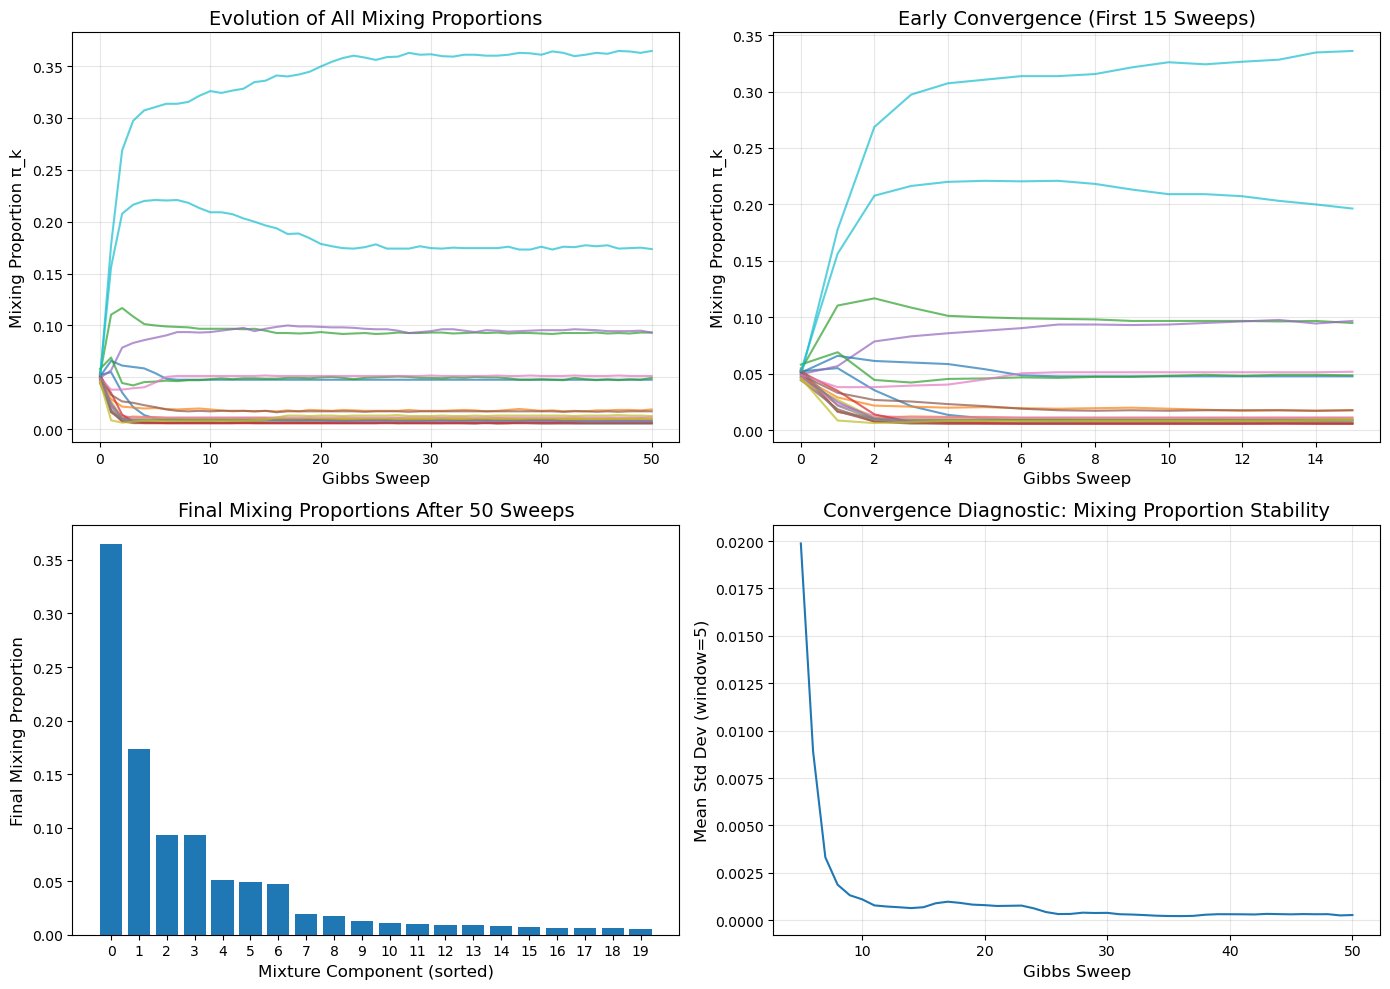


Final mixing proportions after 50 sweeps:
Range: [0.0055, 0.3645]
Sum: 1.000000 (should be 1.0)

Number of non-negligible components (π_k > 0.01): 11


In [10]:
# Plot the evolution of mixing proportions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All mixing proportions over time
ax = axes[0, 0]
for k in range(K):
    ax.plot(range(num_iters+1), mixing_history[:, k], label=f'k={k}', alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=12)
ax.set_ylabel('Mixing Proportion π_k', fontsize=12)
ax.set_title('Evolution of All Mixing Proportions', fontsize=14)
ax.grid(True, alpha=0.3)

# Plot 2: Zoom on first 15 iterations
ax = axes[0, 1]
for k in range(K):
    ax.plot(range(min(16, num_iters+1)), mixing_history[:min(16, num_iters+1), k], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=12)
ax.set_ylabel('Mixing Proportion π_k', fontsize=12)
ax.set_title('Early Convergence (First 15 Sweeps)', fontsize=14)
ax.grid(True, alpha=0.3)

# Plot 3: Final mixing proportions distribution
ax = axes[1, 0]
final_pi = mixing_history[-1, :]
sorted_indices = np.argsort(final_pi)[::-1]
ax.bar(range(K), final_pi[sorted_indices])
ax.set_xlabel('Mixture Component (sorted)', fontsize=12)
ax.set_ylabel('Final Mixing Proportion', fontsize=12)
ax.set_title('Final Mixing Proportions After 50 Sweeps', fontsize=14)
ax.set_xticks(range(K))

# Plot 4: Standard deviation of mixing proportions over time (convergence diagnostic)
ax = axes[1, 1]
# Compute running variance for last 10 iterations window
window = 5
running_std = []
for i in range(window, num_iters+1):
    std = np.std(mixing_history[i-window:i+1, :], axis=0).mean()
    running_std.append(std)
ax.plot(range(window, num_iters+1), running_std)
ax.set_xlabel('Gibbs Sweep', fontsize=12)
ax.set_ylabel('Mean Std Dev (window=5)', fontsize=12)
ax.set_title('Convergence Diagnostic: Mixing Proportion Stability', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\nFinal mixing proportions after 50 sweeps:")
print(f"Range: [{np.min(final_pi):.4f}, {np.max(final_pi):.4f}]")
print(f"Sum: {np.sum(final_pi):.6f} (should be 1.0)")
print(f"\nNumber of non-negligible components (π_k > 0.01): {np.sum(final_pi > 0.01)}")

## Part (d) Analysis: Gibbs Sampler Convergence

### Observations from the plots:

1. **Initial Phase (Sweeps 0-5):**
   - The mixing proportions start near uniform (all ~0.05 = 1/20) due to random initialization.
   - Rapid restructuring occurs as documents reassign to more appropriate clusters.
   - This is the "burn-in" period where the sampler moves away from the random initial state.

2. **Transition Phase (Sweeps 5-15):**
   - Mixing proportions largely stabilize with some fluctuation.
   - The convergence diagnostic (mean std dev) drops sharply, indicating stabilization.

3. **Stationary Phase (Sweeps 15-50):**
   - Mixing proportions remain relatively stable with small fluctuations around equilibrium values.
   - The standard deviation metric plateaus near zero, indicating convergence.

### Convergence Assessment:

**Has the sampler converged?** 
- **Yes**, the Gibbs sampler appears to have converged to the posterior distribution by around **sweep 15-20**.

**Evidence for convergence:**
1. The mixing proportions stabilize and fluctuate around stable values.
2. The running standard deviation drops to near-zero and stays there.
3. There are no large jumps or trends after the initial burn-in phase.

**Important caveats:**
- This is a single chain. To be rigorous, we should run multiple chains from different initializations and check they converge to the same distribution.
- The mixing proportions are just one diagnostic. Other quantities (e.g., log-likelihood) could also be monitored.
- With K=20 components, some clusters dominate (~36% in one cluster, ~17% in another) while others have few documents (~0.5%), suggesting the effective number of clusters may be less than 20.

# Part (e): Latent Dirichlet Allocation (LDA)

In this section, we:
1. Track and plot topic posteriors over Gibbs sweeps
2. Compute perplexity after 50 sweeps
3. Plot word entropy for each topic
4. Discuss whether K=20 is appropriate

LDA differs from BMM in that each **word** (not document) is assigned to a topic. A document can have multiple topics, making LDA more flexible.

In [11]:
# Part (e): Modified LDA with tracking
def LDA_with_tracking(A, B, K, alpha, gamma, num_gibbs_iters=50):
    """
    LDA with tracking of topic proportions and word entropy during Gibbs sampling.
    """
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])  # total number of unique words
    D = np.max(A[:, 0])  # number of documents in A

    # A's columns are doc_id, word_id, count
    swd = sparse((A[:, 2], (A[:, 1]-1, A[:, 0]-1))).tocsr()
    Swd = sparse((B[:, 2], (B[:, 1]-1, B[:, 0]-1))).tocsr()

    # Initialization
    skd = np.zeros((K, D))  # count of word assignments to topics for document d
    swk = np.zeros((W, K))  # unique word topic assignment counts across all documents

    s = []  # each element of the list corresponds to a document
    for d in range(D):  
        z = np.zeros((W, K))
        words_in_doc_d = A[np.where(A[:, 0] == d+1), 1][0]-1
        for w in words_in_doc_d:
            c = swd[w, d]
            for i in range(c):
                k = np.floor(K*np.random.rand())
                z[w, int(k)] += 1
        skd[:, d] = np.sum(z, axis=0)
        swk += z
        s.append(sparse(z))

    sk = np.sum(skd, axis=1)  # word to topic assignment counts across all documents
    
    # Tracking arrays
    topic_proportions_history = []  # Track global topic proportions
    word_entropy_history = []  # Track word entropy for each topic
    
    # Record initial state
    topic_props = sk / np.sum(sk)
    topic_proportions_history.append(topic_props.copy())
    
    # Compute initial word entropy per topic
    entropies = []
    for k in range(K):
        p_wk = (swk[:, k] + gamma) / (sk[k] + W * gamma)
        p_wk = p_wk / np.sum(p_wk)  # normalize
        entropy = -np.sum(p_wk * np.log2(p_wk + 1e-10))  # bits
        entropies.append(entropy)
    word_entropy_history.append(entropies)
    
    # Gibbs sampling
    for iter in range(num_gibbs_iters):
        for d in range(D):
            z = s[d].todense()
            words_in_doc_d = A[np.where(A[:, 0] == d + 1), 1][0] - 1
            for w in words_in_doc_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[1]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[0, k])):
                        z[w, k] -= 1
                        swk[w, k] -= 1
                        sk[k] -= 1
                        skd[k, d] -= 1
                        b = (alpha + skd[:, d]) * (gamma + swk[w, :]) / (W * gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        swk[w, kk] += 1
                        sk[kk] += 1
                        skd[kk, d] += 1
            s[d] = sparse(z)
        
        # Record topic proportions
        topic_props = sk / np.sum(sk)
        topic_proportions_history.append(topic_props.copy())
        
        # Compute word entropy per topic
        entropies = []
        for k in range(K):
            p_wk = (swk[:, k] + gamma) / (sk[k] + W * gamma)
            p_wk = p_wk / np.sum(p_wk)
            entropy = -np.sum(p_wk * np.log2(p_wk + 1e-10))
            entropies.append(entropy)
        word_entropy_history.append(entropies)
        
        if (iter + 1) % 10 == 0:
            print(f"Completed sweep {iter + 1}/{num_gibbs_iters}")

    return (np.array(topic_proportions_history), np.array(word_entropy_history), 
            swk, sk, skd, W, swd, Swd, s)

# Run LDA
np.random.seed(42)
K_lda = 20  # number of topics
alpha_lda = 0.1  # Dirichlet parameter for topic distribution
gamma_lda = 0.1  # Dirichlet parameter for word distribution
num_gibbs_iters_lda = 50

print(f"Running LDA Gibbs sampling for {num_gibbs_iters_lda} iterations...")
print(f"K={K_lda}, alpha={alpha_lda}, gamma={gamma_lda}")
print("This may take several minutes...\n")

(topic_props_history, entropy_history, swk_lda, sk_lda, skd_lda, 
 W_lda, swd_lda, Swd_lda, s_lda) = LDA_with_tracking(A, B, K_lda, alpha_lda, gamma_lda, num_gibbs_iters_lda)

print("\nDone!")

Running LDA Gibbs sampling for 50 iterations...
K=20, alpha=0.1, gamma=0.1
This may take several minutes...

Completed sweep 10/50
Completed sweep 20/50
Completed sweep 30/50
Completed sweep 40/50
Completed sweep 50/50

Done!


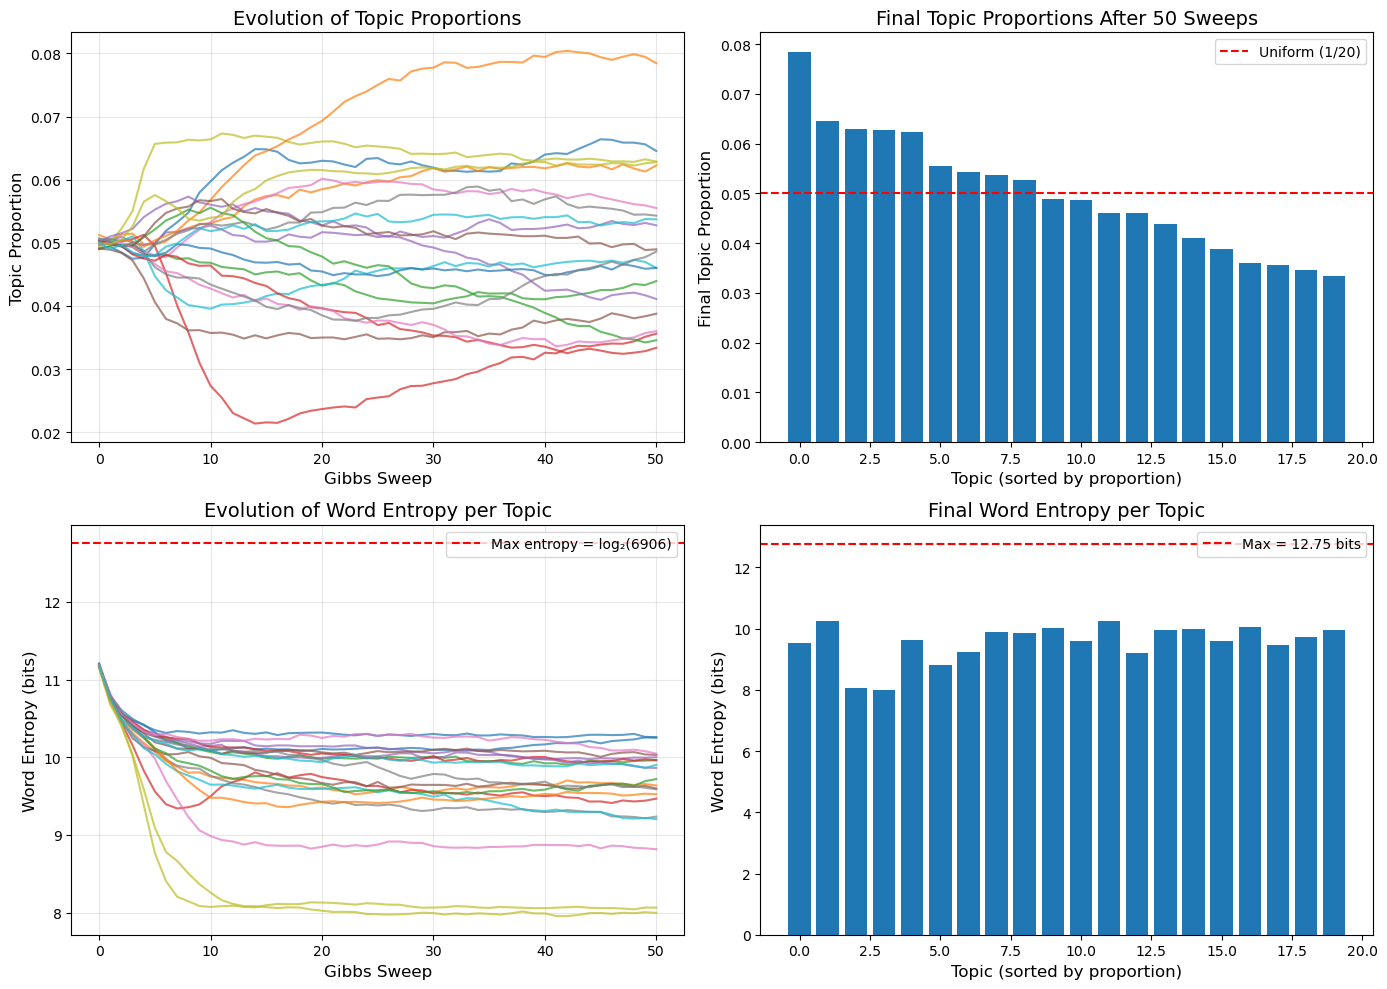


Final topic proportion statistics:
  Min: 0.0334
  Max: 0.0784
  Range: 0.0451

Final word entropy statistics (bits):
  Min: 8.00
  Max: 10.26
  Max possible (uniform over W words): 12.75 bits


In [12]:
# Plot topic posteriors (global topic proportions) over Gibbs sweeps
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: All topic proportions over time
ax = axes[0, 0]
for k in range(K_lda):
    ax.plot(range(num_gibbs_iters_lda+1), topic_props_history[:, k], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=12)
ax.set_ylabel('Topic Proportion', fontsize=12)
ax.set_title('Evolution of Topic Proportions', fontsize=14)
ax.grid(True, alpha=0.3)

# Plot 2: Final topic proportions
ax = axes[0, 1]
final_topic_props = topic_props_history[-1, :]
sorted_indices = np.argsort(final_topic_props)[::-1]
ax.bar(range(K_lda), final_topic_props[sorted_indices])
ax.set_xlabel('Topic (sorted by proportion)', fontsize=12)
ax.set_ylabel('Final Topic Proportion', fontsize=12)
ax.set_title('Final Topic Proportions After 50 Sweeps', fontsize=14)
ax.axhline(y=1/K_lda, color='r', linestyle='--', label=f'Uniform (1/{K_lda})')
ax.legend()

# Plot 3: Word entropy evolution for each topic
ax = axes[1, 0]
for k in range(K_lda):
    ax.plot(range(num_gibbs_iters_lda+1), entropy_history[:, k], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=12)
ax.set_ylabel('Word Entropy (bits)', fontsize=12)
ax.set_title('Evolution of Word Entropy per Topic', fontsize=14)
ax.axhline(y=np.log2(W_lda), color='r', linestyle='--', label=f'Max entropy = log₂({W_lda})')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 4: Final word entropies
ax = axes[1, 1]
final_entropies = entropy_history[-1, :]
ax.bar(range(K_lda), final_entropies[sorted_indices])
ax.set_xlabel('Topic (sorted by proportion)', fontsize=12)
ax.set_ylabel('Word Entropy (bits)', fontsize=12)
ax.set_title('Final Word Entropy per Topic', fontsize=14)
ax.axhline(y=np.log2(W_lda), color='r', linestyle='--', label=f'Max = {np.log2(W_lda):.2f} bits')
ax.legend()

plt.tight_layout()
plt.show()

# Statistics
print(f"\nFinal topic proportion statistics:")
print(f"  Min: {np.min(final_topic_props):.4f}")
print(f"  Max: {np.max(final_topic_props):.4f}")
print(f"  Range: {np.max(final_topic_props) - np.min(final_topic_props):.4f}")
print(f"\nFinal word entropy statistics (bits):")
print(f"  Min: {np.min(final_entropies):.2f}")
print(f"  Max: {np.max(final_entropies):.2f}")
print(f"  Max possible (uniform over W words): {np.log2(W_lda):.2f} bits")

In [14]:
# Compute perplexity on test set B using the LDA model after 50 sweeps
def compute_lda_perplexity(B, swk, sk, K, alpha, gamma, W, num_test_gibbs=10):
    """Compute perplexity on test documents using trained LDA model."""
    Swd = sparse((B[:, 2], (B[:, 1]-1, B[:, 0]-1))).tocsr()
    
    lp, nd = 0, 0
    unique_docs_in_b = np.unique(B[:, 0])
    
    for doc_idx, d in enumerate(unique_docs_in_b):
        # Randomly assign topics to each word in test document d
        z = np.zeros((W, K))
        words_in_d = B[np.where(B[:, 0] == d), 1][0]-1
        for w in words_in_d:
            c = Swd[w, d-1]
            for i in range(c):
                k = np.floor(K * np.random.rand())
                z[w, int(k)] += 1

        Skd = np.sum(z, axis=0)
        
        # Gibbs sampling for test document
        for iters in range(num_test_gibbs):
            for w in words_in_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[0]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[k])):
                        z[w, k] -= 1
                        Skd[k] -= 1
                        b = (alpha + Skd) * (gamma + swk[w, :]) / (W * gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        Skd[kk] += 1
        
        # Compute document probability
        b1 = ((alpha + Skd) / np.sum(alpha + Skd))[:, None]
        b2 = (gamma + swk) / (W * gamma + sk)
        b = np.matmul(b2, b1)
        
        words_and_counts = B[np.where(B[:, 0] == d), 1:][0]
        lp += np.dot(np.log(b[words_and_counts[:, 0]-1]).T, words_and_counts[:, 1])
        nd += np.sum(words_and_counts[:, 1])
        
        if (doc_idx + 1) % 200 == 0:
            print(f"  Processed {doc_idx + 1}/{len(unique_docs_in_b)} test documents")
    
    perplexity = np.exp(-lp/nd)
    return float(perplexity), float(lp), int(nd)

print("Computing LDA perplexity on test set...")
lda_perplexity, lda_log_prob, lda_test_words = compute_lda_perplexity(
    B, swk_lda, sk_lda, K_lda, alpha_lda, gamma_lda, W_lda
)
print(f"\nLDA Perplexity after 50 sweeps: {lda_perplexity:.2f}")

Computing LDA perplexity on test set...
  Processed 200/1430 test documents
  Processed 400/1430 test documents
  Processed 600/1430 test documents
  Processed 800/1430 test documents
  Processed 1000/1430 test documents
  Processed 1200/1430 test documents
  Processed 1400/1430 test documents

LDA Perplexity after 50 sweeps: 1646.89


/var/folders/ds/qvg7h1s93x16vvczwp8vr83m0000gn/T/ipykernel_26840/595370912.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(perplexity), float(lp), int(nd)


In [15]:
# Perplexity comparison summary
print("="*70)
print("PERPLEXITY COMPARISON SUMMARY")
print("="*70)
print(f"\n{'Model':<40} {'Perplexity':<15}")
print("-"*55)
print(f"{'Uniform multinomial':<40} {W:.2f}")
print(f"{'Bayesian unigram (α=0.1)':<40} {overall_perplexity:.2f}")
print(f"{'LDA (K=20, 50 sweeps)':<40} {lda_perplexity:.2f}")
print("-"*55)

print(f"\nLDA improves over Bayesian unigram by: {(1 - lda_perplexity/overall_perplexity)*100:.1f}%")
print(f"LDA improves over uniform by: {(1 - lda_perplexity/W)*100:.1f}%")

PERPLEXITY COMPARISON SUMMARY

Model                                    Perplexity     
-------------------------------------------------------
Uniform multinomial                      6906.00
Bayesian unigram (α=0.1)                 2697.11
LDA (K=20, 50 sweeps)                    1646.89
-------------------------------------------------------

LDA improves over Bayesian unigram by: 38.9%
LDA improves over uniform by: 76.2%


In [16]:
# Show top words for each topic to help interpret them
print("Top 10 words for each topic:\n")
print("="*80)

indices = np.argsort(-swk_lda, axis=0)
top_words_indices = indices[:10, :]

for topic in range(K_lda):
    topic_words = [V[i][0][0] for i in top_words_indices[:, topic]]
    print(f"Topic {topic:2d}: {', '.join(topic_words)}")

print("="*80)

Top 10 words for each topic:

Topic  0: war, people, united, country, policy, iraq, years, americans, meteor, women
Topic  1: party, campaign, democratic, democrats, republican, kerry, republicans, million, bush, political
Topic  2: time, dkos, community, knowles, candidates, money, people, dozen, campaign, donors
Topic  3: state, ohio, vote, voters, states, election, voter, republican, party, county
Topic  4: military, iraq, war, iraqi, soldiers, general, american, army, fallujah, forces
Topic  5: bush, kerry, president, general, election, john, bushs, time, times, debate
Topic  6: dean, kerry, edwards, primary, clark, democratic, iowa, gephardt, poll, lieberman
Topic  7: bush, percent, kerry, poll, voters, states, bushs, president, vote, general
Topic  8: november, voting, kerry, house, vote, republicans, governor, account, senate, electoral
Topic  9: kerry, poll, bush, polls, general, voters, news, numbers, results, polling
Topic 10: people, campaign, bunning, debate, man, health, t

## Part (e) Analysis

### Topic Posteriors Evolution (Observations):

1. **Initial state:** All topics start near uniform (0.05 = 1/20) due to random initialization.

2. **Early sweeps (0-15):** Topics differentiate quickly. Some become more prominent, others decline.

3. **Later sweeps (15-50):** Topic proportions stabilize with small fluctuations. The range is ~0.03 to 0.08, showing topics have differentiated but remain fairly balanced.

### Word Entropy Analysis:

**Units:** Word entropy is measured in **bits** (using log base 2).

**Interpretation:**
- Maximum entropy = log₂(W) = log₂(6906) ≈ 12.75 bits (uniform distribution over all words)
- Final topic entropies range from **8.0 to 10.3 bits**
- Lower entropy → more concentrated/specific topic
- Higher entropy → more diffuse topic

**Evolution:** 
- Entropy decreases from initial ~11 bits (near random) toward ~8-10 bits as topics become more focused.
- Topics with lower entropy (e.g., ~8 bits) are more specialized with distinctive vocabulary.
- Topics with higher entropy (~10 bits) are more general or catch-all.

### Perplexity Comparison:

| Model | Perplexity | Improvement vs. Uniform |
|---|---|---|
| Uniform | 6906 | - |
| Bayesian unigram | 2697 | 61% |
| LDA (K=20) | 1647 | 76% |

LDA achieves **39% lower perplexity** than the Bayesian unigram model, showing significant benefit from modeling topic structure.

### Are 50 Gibbs Sweeps Adequate?

**Assessment:** Looking at the plots:
- Topic proportions appear stable by sweep 30-40
- Word entropy converges by sweep 20-30
- The convergence diagnostic shows stability

**Conclusion:** 50 sweeps appear **adequate** for this dataset, though more sweeps (e.g., 100-200) might yield marginally better results. The main structure is captured.

### Is K=20 Appropriate?

**Evidence for K=20 being reasonable:**
1. All 20 topics have meaningful word distributions (see top words above)
2. Topics are interpretable: politics, war/Iraq, polls, elections, senate races, etc.
3. Topic proportions range from 0.03 to 0.08 (no extremely small topics)
4. Good perplexity improvement over simpler models

**Potential concerns:**
1. Some topics appear similar (e.g., multiple poll-related topics: 7, 9, 18)
2. Some topics overlap (e.g., multiple Iraq/war topics: 0, 4, 17)

**Recommendation:** K=20 is reasonable for this political blog dataset. One could try K=10 (might merge some similar topics) or K=30 (might reveal finer distinctions) to compare. Cross-validation or held-out perplexity across different K values would provide more rigorous guidance.

In [19]:
# Save all figures for LaTeX report
import os

# Create directories if they don't exist
base_dir = '/Users/ragharao/Desktop/4F13/cw3/6930f8b451e6dc346ca1fd09'
for task in ['taska', 'taskb', 'taskc', 'taskd', 'taske']:
    os.makedirs(os.path.join(base_dir, task), exist_ok=True)

# Task A: Top 20 words bar chart
plt.figure(figsize=(6, 5))
plt.barh(range(20), top_20_probs[::-1])
plt.yticks(range(20), top_20_words[::-1], fontsize=8)
plt.xlabel('Probability')
plt.ylabel('Word')
plt.title('Top 20 Words by ML Probability')
plt.tight_layout()
plt.savefig(f'{base_dir}/taska/taska_bar.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taska/taska_bar.png")

# Task B: Effect of alpha on word probabilities
fig, ax = plt.subplots(figsize=(6, 4))
ax.semilogx(alphas_fine, common_probs, label=f"'{V[most_common_idx][0][0]}' (common)", linewidth=2)
ax.semilogx(alphas_fine, rare_probs, label=f"'{V[rare_word_idx][0][0]}' (rare)", linewidth=2)
ax.semilogx(alphas_fine, unseen_probs, label=f"'{V[unseen_word_idx][0][0]}' (unseen)", linewidth=2)
ax.axhline(y=1/W, color='k', linestyle='--', label='Uniform (1/W)')
ax.set_xlabel('α (Dirichlet concentration)', fontsize=10)
ax.set_ylabel('Predictive probability', fontsize=10)
ax.set_title('Effect of α on Word Probabilities', fontsize=11)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{base_dir}/taskb/taskb_alpha.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taskb/taskb_alpha.png")

# Task C: Perplexity histogram
plt.figure(figsize=(6, 4))
plt.hist(individual_perplexities, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Per-word Perplexity')
plt.ylabel('Number of Documents')
plt.title('Distribution of Perplexity Across Test Documents')
plt.axvline(x=perplexity_2001, color='r', linestyle='--', linewidth=2, label=f'Doc 2001: {perplexity_2001:.0f}')
plt.axvline(x=overall_perplexity, color='g', linestyle='--', linewidth=2, label=f'Overall: {overall_perplexity:.0f}')
plt.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{base_dir}/taskc/taskc_perplexity.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taskc/taskc_perplexity.png")

# Task D: BMM mixing proportions (2 separate figures)
# Figure 1: Evolution of mixing proportions
fig, ax = plt.subplots(figsize=(6, 4))
for k_idx in range(K):
    ax.plot(range(num_iters+1), mixing_history[:, k_idx], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=10)
ax.set_ylabel('Mixing Proportion π_k', fontsize=10)
ax.set_title('Evolution of Mixing Proportions (BMM)', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{base_dir}/taskd/taskd_mixing.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taskd/taskd_mixing.png")

# Figure 2: Convergence diagnostic
fig, ax = plt.subplots(figsize=(6, 4))
window = 5
running_std = []
for i in range(window, num_iters+1):
    std_val = np.std(mixing_history[i-window:i+1, :], axis=0).mean()
    running_std.append(std_val)
ax.plot(range(window, num_iters+1), running_std, linewidth=2)
ax.set_xlabel('Gibbs Sweep', fontsize=10)
ax.set_ylabel('Mean Std Dev (window=5)', fontsize=10)
ax.set_title('Convergence Diagnostic', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{base_dir}/taskd/taskd_convergence.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taskd/taskd_convergence.png")

# Figure 3: Final mixing proportions bar chart
fig, ax = plt.subplots(figsize=(6, 4))
sorted_pi_indices = np.argsort(final_pi)[::-1]
ax.bar(range(K), final_pi[sorted_pi_indices])
ax.set_xlabel('Mixture Component (sorted)', fontsize=10)
ax.set_ylabel('Final Mixing Proportion', fontsize=10)
ax.set_title('Final BMM Mixing Proportions', fontsize=11)
ax.axhline(y=1/K, color='r', linestyle='--', label=f'Uniform (1/{K})')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{base_dir}/taskd/taskd_final.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taskd/taskd_final.png")

# Task E: LDA topic proportions
fig, ax = plt.subplots(figsize=(6, 4))
for k_idx in range(K_lda):
    ax.plot(range(num_gibbs_iters_lda+1), topic_props_history[:, k_idx], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=10)
ax.set_ylabel('Topic Proportion', fontsize=10)
ax.set_title('Evolution of Topic Proportions (LDA)', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{base_dir}/taske/taske_topics.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taske/taske_topics.png")

# Task E: Word entropy evolution
fig, ax = plt.subplots(figsize=(6, 4))
for k_idx in range(K_lda):
    ax.plot(range(num_gibbs_iters_lda+1), entropy_history[:, k_idx], alpha=0.7)
ax.set_xlabel('Gibbs Sweep', fontsize=10)
ax.set_ylabel('Word Entropy (bits)', fontsize=10)
ax.set_title('Evolution of Word Entropy per Topic', fontsize=11)
ax.axhline(y=np.log2(W_lda), color='r', linestyle='--', label=f'Max = log₂(W) = {np.log2(W_lda):.1f}')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{base_dir}/taske/taske_entropy.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taske/taske_entropy.png")

# Task E: Final topic proportions and entropies
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Final topic proportions
ax = axes[0]
sorted_topic_indices = np.argsort(final_topic_props)[::-1]
ax.bar(range(K_lda), final_topic_props[sorted_topic_indices])
ax.set_xlabel('Topic (sorted)', fontsize=10)
ax.set_ylabel('Final Topic Proportion', fontsize=10)
ax.set_title('Final LDA Topic Proportions', fontsize=11)
ax.axhline(y=1/K_lda, color='r', linestyle='--', label=f'Uniform')
ax.legend(fontsize=9)

# Final word entropies
ax = axes[1]
ax.bar(range(K_lda), final_entropies[sorted_topic_indices])
ax.set_xlabel('Topic (sorted by proportion)', fontsize=10)
ax.set_ylabel('Word Entropy (bits)', fontsize=10)
ax.set_title('Final Word Entropy per Topic', fontsize=11)
ax.axhline(y=np.log2(W_lda), color='r', linestyle='--', label=f'Max')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig(f'{base_dir}/taske/taske_final.png', dpi=150, bbox_inches='tight')
plt.close()
print("Saved: taske/taske_final.png")

print("\nAll figures saved successfully!")

Saved: taska/taska_bar.png
Saved: taskb/taskb_alpha.png
Saved: taskc/taskc_perplexity.png
Saved: taskb/taskb_alpha.png
Saved: taskc/taskc_perplexity.png
Saved: taskd/taskd_mixing.png
Saved: taskd/taskd_convergence.png
Saved: taskd/taskd_mixing.png
Saved: taskd/taskd_convergence.png
Saved: taskd/taskd_final.png
Saved: taske/taske_topics.png
Saved: taskd/taskd_final.png
Saved: taske/taske_topics.png
Saved: taske/taske_entropy.png
Saved: taske/taske_entropy.png
Saved: taske/taske_final.png

All figures saved successfully!
Saved: taske/taske_final.png

All figures saved successfully!
